## Copy data to new directory

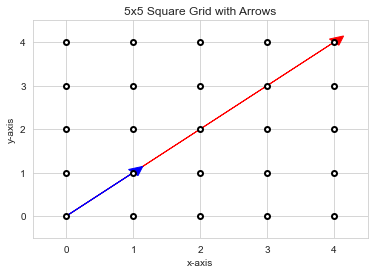

In [4]:
import matplotlib.pyplot as plt

# Define the grid
x = [0, 1, 2, 3, 4]
y = [0, 1, 2, 3, 4]

# Define the arrow endpoints
arrow1_start = [0, 0]
arrow1_end = [4, 4]
arrow2_start = [0, 0]
arrow2_end = [1, 1]

# Create the plot
fig, ax = plt.subplots()

# Plot the grid
for i in range(len(x)):
    for j in range(len(y)):
        ax.plot(x[i], y[j], 'o', color='white', markersize=5, mec='black', mew=2)

# Add the arrows to the plot
ax.arrow(arrow1_start[0], arrow1_start[1], arrow1_end[0]-arrow1_start[0], arrow1_end[1]-arrow1_start[1],
         head_width=0.2, head_length=0.2, fc='red', ec='red')
ax.arrow(arrow2_start[0], arrow2_start[1], arrow2_end[0]-arrow2_start[0], arrow2_end[1]-arrow2_start[1],
         head_width=0.2, head_length=0.2, fc='blue', ec='blue')

# Set the axis range and gridlines
ax.set_xlim([-0.5, 4.5])
ax.set_ylim([-0.5, 4.5])
ax.set_xticks(x)
ax.set_yticks(y)
ax.grid(True)

# Set the axis labels
ax.set_xlabel('x-axis')
ax.set_ylabel('y-axis')

# Set the plot title
ax.set_title('5x5 Square Grid with Arrows')

plt.savefig("/home/dell/clash/demo.png",dpi=300)
# Show the plot
plt.show()

In [5]:
import numpy as np

# Generate 1000 random 100x1 vectors
x = np.random.rand(1000, 100)

# Initialize vector d
d = np.zeros((100, 1))

# Define the target mean correlation
target_mean_corr = -0.1

# Iterate until the mean correlation is close enough to the target value
i =0
while i>10000:
    print(i)
    # Calculate the correlations between x and d
    corrs = np.dot(x, d)

    # Calculate the current mean correlation
    mean_corr = np.mean(corrs)

    # Calculate the correlation adjustment factor
    corr_adjustment = target_mean_corr - mean_corr

    # If the mean correlation is close enough to the target value, exit the loop
    if abs(corr_adjustment) < 0.01:
        break

    # Update d by adjusting the correlations with the adjustment factor
    d += (corr_adjustment * x.mean(axis=0)).reshape(-1, 1)
    i+=1

# Check that the final mean correlation is close enough to the target value
final_mean_corr = np.mean(np.dot(x, d))
print("Final mean correlation:", final_mean_corr)

Final mean correlation: 0.0


In [6]:
import os
import shutil
import pandas as pd
from os.path import join as opj

source_dir = r'/mnt/data/Project/DCM/BIDS/BIDS'
output_dir = r'/mnt/data/tmp/Data2Heli'
# read data from source directory
participants_tsv = r'/mnt/workdir/DCM/BIDS/participants.tsv'
participants_data = pd.read_csv(participants_tsv, sep='\t')

# copy meg data
data = participants_data.query('meg_neuro==1')
pid = data['Participant_ID'].to_list()
subject_list = pid
subject_list = ['sub_'+str(id).zfill(3) for id in range(64,83)]

# creat directory structure in output directory
def copy_meg_resting(sub_id):
    original_dir = r'/mnt/workdir/DCM/sourcedata'
    output_dir = '/mnt/data/tmp/Data2Heli'

    sourMegDir = opj(original_dir, sub_id, 'NeuroData','MEG')
    targMegDir = opj(output_dir, sub_id, 'MEG')

    if not os.path.exists(targMegDir):
        os.makedirs(targMegDir)

    file_list = os.listdir(sourMegDir)
    target_files = []
    for f in file_list:
        if 'rest' in f:
            target_files.append(f)
        else:
            continue

    for target_file in target_files:
        source_file_path = opj(sourMegDir,target_file)
        target_file_path = opj(targMegDir,target_file)
        if '.fif' in target_file:
            shutil.copy(source_file_path,target_file_path)
        elif '.ds' in target_file:
            shutil.copytree(source_file_path,target_file_path)

for sub in subject_list:
    copy_meg_resting(sub)

In [7]:
import os
import shutil
import pandas as pd
from os.path import join as opj
# copy fmri resting data and T1
def copy_mri_resting(sub_id):
    original_dir = r'/mnt/workdir/DCM/BIDS'
    output_dir = '/mnt/data/tmp/Data2HNY'

    sourMriDir = opj(original_dir, sub_id)
    targMriDir = opj(output_dir, sub_id.replace('-','-'))

    if not os.path.exists(targMriDir):
        os.makedirs(targMriDir)
    else:
        return

    mri_modes = ['anat','func','dwi']

    for mode in mri_modes:
        if mode in ['anat','dwi']:
            source_file_path = opj(sourMriDir,mode)
            target_file_path = opj(targMriDir,mode)
            try:
                shutil.copytree(source_file_path,target_file_path)
            except:
                print("The ",sub_id,"didn't have", mode)
                continue

        elif mode == 'func':
            file_list = os.listdir(opj(sourMriDir,'func'))
            target_files = []
            for f in file_list:
                if 'rest' in f:
                    target_files.append(f)
                    #print(f)
                else:
                    continue
            for target_file in target_files:
                source_file_path = opj(sourMriDir,mode,target_file)
                target_file_path = opj(targMriDir,mode,target_file)
                if not os.path.exists(opj(targMriDir,mode)):
                    os.makedirs(opj(targMriDir,mode))
                shutil.copy(source_file_path,target_file_path)

participants_tsv = r'/mnt/workdir/DCM/BIDS/participants.tsv'
participants_data = pd.read_csv(participants_tsv, sep='\t')

# copy meg data
data = participants_data.query('game1_fmri>=0.5')
subject_list = data['Participant_ID'].to_list()
subject_list = [s.replace('-','-') for s in subject_list]
subject_list.remove('sub-015')

for sub in subject_list:
    copy_mri_resting(sub)

The  sub-010 didn't have dwi
The  sub-011 didn't have dwi
The  sub-012 didn't have dwi
The  sub-016 didn't have dwi
The  sub-018 didn't have dwi
The  sub-022 didn't have dwi
The  sub-023 didn't have dwi
The  sub-024 didn't have dwi
The  sub-025 didn't have dwi
The  sub-029 didn't have dwi
The  sub-031 didn't have dwi
The  sub-032 didn't have dwi
The  sub-036 didn't have dwi
The  sub-037 didn't have dwi
The  sub-043 didn't have dwi
The  sub-046 didn't have dwi
The  sub-049 didn't have dwi
The  sub-050 didn't have dwi
The  sub-053 didn't have dwi
The  sub-055 didn't have dwi
The  sub-059 didn't have dwi
The  sub-060 didn't have dwi
The  sub-061 didn't have dwi
The  sub-062 didn't have dwi
The  sub-063 didn't have dwi
The  sub-064 didn't have dwi
The  sub-065 didn't have dwi
The  sub-067 didn't have dwi
The  sub-068 didn't have dwi
The  sub-069 didn't have dwi
The  sub-070 didn't have dwi
The  sub-071 didn't have dwi
The  sub-072 didn't have dwi
The  sub-073 didn't have dwi
The  sub-074 d

In [8]:
subject_list[0].rep

AttributeError: 'str' object has no attribute 'rep'

## copy event file to new directory

In [ ]:
import os
import shutil
from os.path import join as opj

source_dir = r'/mnt/data/Project/DCM/BIDS/derivatives/fmriprep_surfer'
output_dir = r'/mnt/data/Project/DCM/BIDS/derivatives/Events'
# read data from source directory
sub_list = ['sub-{}'.format(str(idx).zfill(3)) for idx in range(12,48)]
# creat directory structure in output directory
for i,sub in enumerate(sub_list):
    if not os.path.exists(opj(source_dir, sub, 'events')):
        print(sub, " haven't event files.")
        continue
    for event_type in ['hexonM2Long', 'hexonM2Short', 'hexonRule']:
        souEvPath = opj(source_dir, sub, 'events',event_type)
        tarSubdir = (opj(output_dir, sub))
        if not os.path.exists(tarSubdir):
            os.mkdir(tarSubdir)
        tarEvPath = opj(output_dir, sub, event_type)
        #shutil.move(souEvPath, tarEvPath)
        
        try:
            shutil.move(souEvPath, tarEvPath)
        except:
            if os.path.exists(tarEvPath):
                print("Error: {} file can't be moved!".format(sub))
            else:
                print("{} haven't {}".format(sub,event_type))

    print("————————{} already been copyed. still have {} subject ————————".format(sub,len(sub_list)-i-1))
    os.rmdir(opj(source_dir, sub, 'events'))
    

## Convert formate of event files to fsl format

In [ ]:
import os
import numpy as np
import pandas as pd 
from os.path import join as opj


def ev2fsl(ev_file,save_dir,prefix):
    ev_info = pd.read_csv(ev_file, sep='\t')
    for group in ev_info.groupby('trial_type'):
        condition = group[0]
        onsets = np.array(group[1].onset.tolist())
        durations = np.array(group[1].duration.tolist())
        if condition in ['sin','cos']:
            amplitudes = np.array(group[1].modulation.tolist())
        else:
            amplitudes = np.array([1]*len(onsets))
        fsl_ev = np.array([onsets,durations,amplitudes]).T.astype('float32')
        #os.makedirs(save_dir)
        np.savetxt(opj(save_dir,'{}_{}.txt'.format(prefix,condition)),fsl_ev,fmt='%.02f',delimiter='\t') # dilimiter: Tab

        
        
def game1tofsl(ev_dir,save_dir,ev_template):
    for i in range(1,7):
        ev_file = opj(ev_dir,ev_template.format(i))
        ev2fsl(ev_file,save_dir,'run{}'.format(i))


        
ev_dir=  r'/mnt/data/Project/DCM/BIDS/derivatives/Events/sub-046/hexonM2Short/6fold'
save_dir= r'/mnt/data/Project/DCM/BIDS/derivatives/Events/sub-046/fsl/hexonM2Short/6fold'
os.makedirs(save_dir)
ev_template= r'sub-046_task-game1_run-{}_events.tsv'

game1tofsl(ev_dir,save_dir,ev_template)

## sum mask

In [ ]:
from nilearn.image import load_img,resample_to_img,math_img,new_img_like

mask1 = load_img(r'/mnt/data/Template/EC_prob_roi.nii.gz')
mask2 = load_img(r'/mnt/data/Template/EC_anatomy_roi.nii.gz')
tar_img = load_img(r'/mnt/data/Project/DCM/BIDS/derivatives/fmriprep_surfer/sub-010/anat/sub-010_space-MNI152NLin2009cAsym_res-2_desc-preproc_T1w.nii.gz')
mask1_tar = resample_to_img(mask1,tar_img,interpolation='nearest')
mask2_tar = resample_to_img(mask2,tar_img,interpolation='nearest')

mask1_data = mask1_tar.get_fdata()
mask2_data = mask2_tar.get_fdata()
mask_sum = mask1_data + mask2_data[:,:,:,0]
mask_sum[mask_sum!=0]=1
mask_sum_img = new_img_like(mask1_tar,mask_sum)
mask_sum_img.to_filename(r'/mnt/data/Template/EC_roi_sum.nii.gz')

## extract EC mask from probabilistic atlas

In [ ]:
import numpy as np

from nilearn.image import load_img,new_img_like


def extract_sp_val(promap_data,sp_val):
    '''extract special value map:
    Parameters:
    promap    :  3d array,1-3 repersents xyz coorodinates
    sp_val :  special value will be extracted and binaryzed.'''
    coordinate_shape = promap_data.shape
    extract_map = np.zeros(coordinate_shape)
    for i in sp_val:
        extract_map[promap_data[:, :, :] == i] = 1
    return extract_map


atlas_path = r'/mnt/workdir/DCM/docs/Reference/EC_ROI/Juelich-maxprob-thr50-2mm.nii.gz'
atlas = load_img(atlas_path)
prob_map = atlas.get_fdata()

ec_mask = extract_sp_val(prob_map,[19,20])
ec = new_img_like(atlas,ec_mask,affine=atlas.affine)
ec.to_filename(r'/mnt/workdir/DCM/docs/Reference/EC_ROI/EC-thr50-2mm.nii.gz')

In [ ]:
from nilearn import plotting
surf_mesh = r'/mnt/workdir/DCM/BIDS/derivatives/fmriprep_surfer/sourcedata/freesurfer/fsaverage/surf/lh.white'
surf_map = r'/mnt/workdir/DCM/docs/Reference/EC_ROI/surfer/Juelich_maxprob_thr0_2mm/1395.L.func.gii'

plt_surf = plotting.view_surf(surf_mesh,surf_map,symmetric_cmap=False)
plt_surf.open_in_browser()

In [ ]:
import nibabel
import os
func_dir = r'/mnt/workdir/DCM/BIDS/derivatives/fmriprep_volume/sub-010/func'
func_name = 'sub-010_task-game1_run-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz'
func_path = os.path.join(func_dir,func_name)
func_img = nibabel.load(func_path)
func_img.affine

In [ ]:
import nibabel
import os
func_dir = r'/mnt/workdir/DCM/BIDS/derivatives/fmriprep_volume/sub-010/func'
func_name = 'sub-010_task-game1_run-1_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz'

func_path = os.path.join(func_dir,func_name)
func_path = r'/mnt/data/Template/res-02_brainMask.nii'
func_img = nibabel.load(func_path)
func_img.get_fdata().max()

In [ ]:
import nibabel
import os
import numpy as np
#func_dir = r'/mnt/workdir/DCM/BIDS/sub-010/func'
#func_name = r'sub-010_task-game1_run-01_bold.nii.gz'
#func_path = os.path.join(func_dir,func_name)
func_path = r'/mnt/data/Template/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-02_desc-brain_mask.nii'
func_img = nibabel.load(func_path)
func_img.get_fdata().min()

# Show the MRI slices of the result

In [ ]:
import pandas as pd
import seaborn as sns

trainset1_phi = pd.read_csv(r'/mnt/workdir/DCM/BIDS/derivatives/Nipype/hexagon/specificTo6/Phi/trainset1_estPhi.csv').query('ifold=="6fold"')
trainset2_phi = pd.read_csv(r'/mnt/workdir/DCM/BIDS/derivatives/Nipype/hexagon/specificTo6/Phi/trainset2_estPhi.csv').query('ifold=="6fold"')

trainset1_phi['session'] = 'sess1'
trainset2_phi['session'] = 'sess2'

phi = pd.concat([trainset1_phi,trainset2_phi])
phi['phi_diff'] = phi['ec_phi'] - phi['vmpfc_phi']
sns.scatterplot(data=phi,x='session',y='phi_diff')

phi_diff_sess1 = abs(phi.query("session=='sess1'")['phi_diff']).to_list()
phi_diff_sess2 = abs(phi.query("session=='sess2'")['phi_diff']).to_list()
from scipy.stats import ttest_ind

t,p = ttest_ind(phi_diff_sess1,phi_diff_sess2)
print('p:',round(p,3))

# add covariate:Age

In [ ]:
from nilearn.plotting import plot_stat_map,plot_glass_brain
from nilearn.image import load_img,math_img
import matplotlib.pyplot as plt

fig,ax = plt.subplots(1,4,figsize=[20,4])
stat_map = load_img(r'/mnt/workdir/DCM/BIDS/derivatives/Nipype/hexagon/specificTo6/training_set/trainsetall/group/all/'
                    r'Age/2ndLevel/_contrast_id_ZF_0004/spmT_0002.nii')

bg_img = load_img(r'/mnt/data/Template/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_desc-brain_T1w.nii.gz')

#plot_stat_map(stat_map_img=stat_map,bg_img=bg_img,cut_coords=[11],threshold=2.3,symmetric_cbar=1,display_mode='x',black_bg=0,figure=fig,
#              axes=ax[0],colorbar=False)
plot_stat_map(stat_map_img=stat_map,bg_img=bg_img,cut_coords=[-4],threshold=2.3,vmax=5,symmetric_cbar=1,display_mode='x',black_bg=0,figure=fig,
              axes=ax[0],colorbar=False)
plot_stat_map(stat_map_img=stat_map,bg_img=bg_img,cut_coords=[-8],threshold=2.3,vmax=5,symmetric_cbar=1,display_mode='y',black_bg=0,figure=fig,
              axes=ax[1],colorbar=False)
plot_stat_map(stat_map_img=stat_map,bg_img=bg_img,cut_coords=[0],threshold=2.3,vmax=5,symmetric_cbar=1,display_mode='y',black_bg=0,figure=fig,
              axes=ax[2],colorbar=False)
plot_stat_map(stat_map_img=stat_map,bg_img=bg_img,cut_coords=[-18],threshold=2.3,vmax=5,symmetric_cbar=1,display_mode='z',black_bg=0,figure=fig,
              axes=ax[3],colorbar=True)

# add covariate:2D acc

# add covariates: age and acc

### Age

### Acc

# EC

## copy data for he li

# Show the MRI slices of the result

In [ ]:
import pandas as pd
import seaborn as sns

trainset1_phi = pd.read_csv(r'/mnt/workdir/DCM/BIDS/derivatives/Nipype/hexagon/specificTo6/Phi/trainset1_estPhi.csv').query('ifold=="6fold"')
trainset2_phi = pd.read_csv(r'/mnt/workdir/DCM/BIDS/derivatives/Nipype/hexagon/specificTo6/Phi/trainset2_estPhi.csv').query('ifold=="6fold"')

trainset1_phi['session'] = 'sess1'
trainset2_phi['session'] = 'sess2'

phi = pd.concat([trainset1_phi,trainset2_phi])
phi['phi_diff'] = phi['ec_phi'] - phi['vmpfc_phi']
sns.scatterplot(data=phi,x='session',y='phi_diff')

phi_diff_sess1 = abs(phi.query("session=='sess1'")['phi_diff']).to_list()
phi_diff_sess2 = abs(phi.query("session=='sess2'")['phi_diff']).to_list()
from scipy.stats import ttest_ind

t,p = ttest_ind(phi_diff_sess1,phi_diff_sess2)
print('p:',round(p,3))

# add covariate:Age

In [ ]:
from nilearn.plotting import plot_stat_map,plot_glass_brain
from nilearn.image import load_img,math_img
import matplotlib.pyplot as plt

fig,ax = plt.subplots(1,4,figsize=[20,4])
stat_map = load_img(r'/mnt/workdir/DCM/BIDS/derivatives/Nipype/hexagon/specificTo6/training_set/trainsetall/group/all/'
                    r'Age/2ndLevel/_contrast_id_ZF_0004/spmT_0002.nii')

bg_img = load_img(r'/mnt/data/Template/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_desc-brain_T1w.nii.gz')

#plot_stat_map(stat_map_img=stat_map,bg_img=bg_img,cut_coords=[11],threshold=2.3,symmetric_cbar=1,display_mode='x',black_bg=0,figure=fig,
#              axes=ax[0],colorbar=False)
plot_stat_map(stat_map_img=stat_map,bg_img=bg_img,cut_coords=[-4],threshold=2.3,vmax=5,symmetric_cbar=1,display_mode='x',black_bg=0,figure=fig,
              axes=ax[0],colorbar=False)
plot_stat_map(stat_map_img=stat_map,bg_img=bg_img,cut_coords=[-8],threshold=2.3,vmax=5,symmetric_cbar=1,display_mode='y',black_bg=0,figure=fig,
              axes=ax[1],colorbar=False)
plot_stat_map(stat_map_img=stat_map,bg_img=bg_img,cut_coords=[0],threshold=2.3,vmax=5,symmetric_cbar=1,display_mode='y',black_bg=0,figure=fig,
              axes=ax[2],colorbar=False)
plot_stat_map(stat_map_img=stat_map,bg_img=bg_img,cut_coords=[-18],threshold=2.3,vmax=5,symmetric_cbar=1,display_mode='z',black_bg=0,figure=fig,
              axes=ax[3],colorbar=True)

# add covariate:2D acc

In [ ]:
from nilearn.plotting import plot_stat_map,plot_glass_brain
from nilearn.image import load_img,math_img
import matplotlib.pyplot as plt

fig,ax = plt.subplots(1,4,figsize=[20,4])
stat_map = load_img(r'/mnt/workdir/DCM/BIDS/derivatives/Nipype/hexagon/specificTo6/training_set/trainsetall/group/all/'
                    r'Acc/2ndLevel/_contrast_id_ZF_0004/spmT_0002.nii')

bg_img = load_img(r'/mnt/data/Template/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_desc-brain_T1w.nii.gz')

#plot_stat_map(stat_map_img=stat_map,bg_img=bg_img,cut_coords=[11],threshold=2.3,symmetric_cbar=1,display_mode='x',black_bg=0,figure=fig,
#              axes=ax[0],colorbar=False)
plot_stat_map(stat_map_img=stat_map,bg_img=bg_img,cut_coords=[6],threshold=2.3,vmax=5,symmetric_cbar=1,display_mode='x',black_bg=0,figure=fig,
              axes=ax[0],colorbar=False)
plot_stat_map(stat_map_img=stat_map,bg_img=bg_img,cut_coords=[24],threshold=2.3,vmax=5,symmetric_cbar=1,display_mode='x',black_bg=0,figure=fig,
              axes=ax[1],colorbar=False)
plot_stat_map(stat_map_img=stat_map,bg_img=bg_img,cut_coords=[-12],threshold=2.3,vmax=5,symmetric_cbar=1,display_mode='y',black_bg=0,figure=fig,
              axes=ax[2],colorbar=False)
plot_stat_map(stat_map_img=stat_map,bg_img=bg_img,cut_coords=[-24],threshold=2.3,vmax=5,symmetric_cbar=1,display_mode='z',black_bg=0,figure=fig,
              axes=ax[3],colorbar=True)

# add covariates: age and acc

### Age

In [ ]:
from nilearn.plotting import plot_stat_map,plot_glass_brain
from nilearn.image import load_img,math_img
import matplotlib.pyplot as plt

fig,ax = plt.subplots(1,4,figsize=[20,4])
stat_map = load_img(r'/mnt/workdir/DCM/BIDS/derivatives/Nipype/hexagon/specificTo6/training_set/trainsetall/group/all/'
                    r'Age_plus_Acc/2ndLevel/_contrast_id_ZF_0004/spmT_0002.nii')

bg_img = load_img(r'/mnt/data/Template/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_desc-brain_T1w.nii.gz')

cut_coords = [-4,2,-18]

#plot_stat_map(stat_map_img=stat_map,bg_img=bg_img,cut_coords=[11],threshold=2.3,symmetric_cbar=1,display_mode='x',black_bg=0,figure=fig,
#              axes=ax[0],colorbar=False)
plot_stat_map(stat_map_img=stat_map,bg_img=bg_img,cut_coords=[-4],threshold=2.3,vmax=5,symmetric_cbar=1,display_mode='x',black_bg=0,figure=fig,
              axes=ax[0],colorbar=False)
plot_stat_map(stat_map_img=stat_map,bg_img=bg_img,cut_coords=[-8],threshold=2.3,vmax=5,symmetric_cbar=1,display_mode='y',black_bg=0,figure=fig,
              axes=ax[1],colorbar=False)
plot_stat_map(stat_map_img=stat_map,bg_img=bg_img,cut_coords=[0],threshold=2.3,vmax=5,symmetric_cbar=1,display_mode='y',black_bg=0,figure=fig,
              axes=ax[2],colorbar=False)
plot_stat_map(stat_map_img=stat_map,bg_img=bg_img,cut_coords=[-18],threshold=2.3,vmax=5,symmetric_cbar=1,display_mode='z',black_bg=0,figure=fig,
              axes=ax[3],colorbar=True)

### Acc

In [ ]:
from nilearn.plotting import plot_stat_map,plot_glass_brain
from nilearn.image import load_img,math_img
import matplotlib.pyplot as plt

fig,ax = plt.subplots(1,4,figsize=[20,4])
stat_map = load_img(r'/mnt/workdir/DCM/BIDS/derivatives/Nipype/hexagon/specificTo6/training_set/trainsetall/group/all/'
                    r'Age_plus_Acc/2ndLevel/_contrast_id_ZF_0004/spmT_0003.nii')

bg_img = load_img(r'/mnt/data/Template/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_desc-brain_T1w.nii.gz')

plot_stat_map(stat_map_img=stat_map,bg_img=bg_img,cut_coords=[6],threshold=2.3,vmax=5,symmetric_cbar=1,display_mode='x',black_bg=0,figure=fig,
              axes=ax[0],colorbar=False)
plot_stat_map(stat_map_img=stat_map,bg_img=bg_img,cut_coords=[24],threshold=2.3,vmax=5,symmetric_cbar=1,display_mode='x',black_bg=0,figure=fig,
              axes=ax[1],colorbar=False)
plot_stat_map(stat_map_img=stat_map,bg_img=bg_img,cut_coords=[-12],threshold=2.3,vmax=5,symmetric_cbar=1,display_mode='y',black_bg=0,figure=fig,
              axes=ax[2],colorbar=False)
plot_stat_map(stat_map_img=stat_map,bg_img=bg_img,cut_coords=[-24],threshold=2.3,vmax=5,symmetric_cbar=1,display_mode='z',black_bg=0,figure=fig,
              axes=ax[3],colorbar=True)

In [ ]:
import numpy as np
from nilearn.plotting import plot_stat_map,plot_roi
from nilearn.image import load_img,math_img,new_img_like
import matplotlib.pyplot as plt

fig,ax = plt.subplots(1,4,figsize=[20,4])
stat_map = load_img(r'/mnt/workdir/DCM/BIDS/derivatives/Nipype/hexagon/specificTo6/training_set/trainsetall/group/'
                    r'hp/2ndLevel/_contrast_id_ZF_0004/spmT_0001.nii')

bg_img = load_img(r'/mnt/data/Template/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_desc-brain_T1w.nii.gz')

vmpfc_mask = load_img(r'/mnt/workdir/DCM/docs/Reference/Park_Grid_Coding/osfstorage-archive/data/Analysis_ROI_nii/mPFC_Grid_roi.nii')

stat_data = stat_map.get_fdata()
stat_data[stat_data<=0]  = np.float64('NaN')
stat_map = new_img_like(stat_map, stat_data)

plot_stat_map(stat_map_img=stat_map,bg_img=bg_img,cut_coords=[-8],threshold=1.6,vmax=4,symmetric_cbar=1,display_mode='x',black_bg=0,figure=fig,
              axes=ax[0],colorbar=False)
plot_stat_map(stat_map_img=stat_map,bg_img=bg_img,cut_coords=[-8],threshold=1.6,vmax=4,symmetric_cbar=1,display_mode='y',black_bg=0,figure=fig,
              axes=ax[1],colorbar=False)
plot_stat_map(stat_map_img=stat_map,bg_img=bg_img,cut_coords=[-4],threshold=1.6,vmax=4,symmetric_cbar=1,display_mode='y',black_bg=0,figure=fig,
              axes=ax[2],colorbar=False)
plot_stat_map(stat_map_img=stat_map,bg_img=bg_img,cut_coords=[3],threshold=1.6,vmax=4,symmetric_cbar=1,display_mode='y',black_bg=0,figure=fig,
              axes=ax[3],colorbar=True)

# EC

In [ ]:
import numpy as np
from nilearn.plotting import plot_stat_map,plot_glass_brain
from nilearn.image import load_img,math_img,new_img_like
import matplotlib.pyplot as plt

fig,ax = plt.subplots(1,4,figsize=[20,4])
stat_map = load_img(r'/mnt/workdir/DCM/BIDS/derivatives/Nipype/hexagon/specificTo6/test_set/EC/group/hp/mean_spmT_align_EC_Phi.nii')

bg_img = load_img(r'/mnt/data/Template/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_desc-brain_T1w.nii.gz')


stat_data = stat_map.get_fdata()
stat_data[stat_data<=0]  = np.float64('NaN')
stat_map = new_img_like(stat_map, stat_data)

plot_stat_map(stat_map_img=stat_map,bg_img=bg_img,cut_coords=[-8],threshold=2.3,vmax=5,symmetric_cbar=1,display_mode='x',black_bg=0,figure=fig,
              axes=ax[0],colorbar=False)
plot_stat_map(stat_map_img=stat_map,bg_img=bg_img,cut_coords=[-8],threshold=2.3,vmax=5,symmetric_cbar=1,display_mode='y',black_bg=0,figure=fig,
              axes=ax[1],colorbar=False)
plot_stat_map(stat_map_img=stat_map,bg_img=bg_img,cut_coords=[-19],threshold=2.3,vmax=5,symmetric_cbar=1,display_mode='z',black_bg=0,figure=fig,
              axes=ax[2],colorbar=False)
plot_stat_map(stat_map_img=stat_map,bg_img=bg_img,cut_coords=[31],threshold=2.3,vmax=5,symmetric_cbar=1,display_mode='z',black_bg=0,figure=fig,
              axes=ax[3],colorbar=True)
% md
# vmpfc

In [ ]:
import numpy as np
from nilearn.plotting import plot_stat_map,plot_glass_brain
from nilearn.image import load_img,math_img,new_img_like
import matplotlib.pyplot as plt

fig,ax = plt.subplots(1,4,figsize=[20,4])
stat_map = load_img(r'/mnt/workdir/DCM/BIDS/derivatives/Nipype/hexagon/specificTo6/test_set/vmpfc/group/hp/mean_spmT_align_vmpfc_Phi.nii')

bg_img = load_img(r'/mnt/data/Template/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_desc-brain_T1w.nii.gz')


stat_data = stat_map.get_fdata()
stat_data[stat_data<=0]  = np.float64('NaN')
stat_map = new_img_like(stat_map, stat_data)

plot_stat_map(stat_map_img=stat_map,bg_img=bg_img,cut_coords=[4],threshold=2.3,vmax=5,symmetric_cbar=1,display_mode='x',black_bg=0,figure=fig,
              axes=ax[0],colorbar=False)
plot_stat_map(stat_map_img=stat_map,bg_img=bg_img,cut_coords=[-33],threshold=2.3,vmax=5,symmetric_cbar=1,display_mode='x',black_bg=0,figure=fig,
              axes=ax[1],colorbar=False)
plot_stat_map(stat_map_img=stat_map,bg_img=bg_img,cut_coords=[3],threshold=2.3,vmax=5,symmetric_cbar=1,display_mode='y',black_bg=0,figure=fig,
              axes=ax[2],colorbar=False)
plot_stat_map(stat_map_img=stat_map,bg_img=bg_img,cut_coords=[-19],threshold=2.3,vmax=5,symmetric_cbar=1,display_mode='z',black_bg=0,figure=fig,
              axes=ax[3],colorbar=True)

## copy data for he li

In [ ]:
from nilearn.plotting import plot_stat_map,plot_glass_brain
from nilearn.image import load_img,math_img
import matplotlib.pyplot as plt

fig,ax = plt.subplots(1,5,figsize=[20,4])
stat_map = load_img(r'/mnt/workdir/DCM/BIDS/derivatives/Nipype/hexagon/specificTo6/training_set/trainsetall/group/adult/2ndLevel/_contrast_id_ZF_0004/spmT_0001.nii')

bg_img = load_img(r'/mnt/data/Template/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_desc-brain_T1w.nii.gz')
stat_map = math_img("np.where(img<0,0,img)",img=stat_map)

plot_stat_map(stat_map_img=stat_map,bg_img=bg_img,cut_coords=[11],threshold=1.69,symmetric_cbar=1,display_mode='x',black_bg=0,figure=fig,
              axes=ax[0],colorbar=False)
#plot_stat_map(stat_map_img=stat_map,bg_img=bg_img,cut_coords=[6],threshold=1.69,vmax=5,symmetric_cbar=1,display_mode='x',black_bg=0,figure=fig,
#              axes=ax[0],colorbar=False)
plot_stat_map(stat_map_img=stat_map,bg_img=bg_img,cut_coords=[24],threshold=1.69,vmax=5,symmetric_cbar=1,display_mode='x',black_bg=0,figure=fig,
              axes=ax[1],colorbar=False)
plot_stat_map(stat_map_img=stat_map,bg_img=bg_img,cut_coords=[-8],threshold=1.69,vmax=5,symmetric_cbar=1,display_mode='y',black_bg=0,figure=fig,
              axes=ax[2],colorbar=False)
plot_stat_map(stat_map_img=stat_map,bg_img=bg_img,cut_coords=[0],threshold=1.69,vmax=5,symmetric_cbar=1,display_mode='y',black_bg=0,figure=fig,
              axes=ax[3],colorbar=False)
plot_stat_map(stat_map_img=stat_map,bg_img=bg_img,cut_coords=[-24],threshold=1.69,vmax=5,symmetric_cbar=1,display_mode='z',black_bg=0,figure=fig,
              axes=ax[4],colorbar=True)

In [ ]:
from scipy.io import loadmat
def plotDesignMatrix(matFile):
    import numpy as np
    import seaborn as sns
    from matplotlib import pyplot as plt
    from scipy.io import loadmat
    from os.path import join as opj
    import os

    fig_filename_full = opj(os.getcwd(), 'spm_mat.png')      # create filename

    spmmat = loadmat(matFile,                           # Using scipy's loadmat function we can access SPM.mat
struct_as_record=False)

    # normalize data
    designMatrix = spmmat['SPM'][0][0].xX[0][0].X[:,:]
    names = [i[0] for i in spmmat['SPM'][0][0].xX[0][0].name[0]][:]

    normed_design = designMatrix / np.abs(designMatrix).max(axis=0)

    # save figure
    fig_f, ax_f = plt.subplots(figsize=(30, 30))
    plt.imshow(normed_design, aspect='auto', cmap='gray', interpolation='none')
    ax_f.set_ylabel('Volume id')
    ax_f.set_xticks(np.arange(len(names)))
    ax_f.set_xticklabels(names, rotation=30)
    plt.show()
    #fig_f.savefig(r'/mnt/workdir/DCM/tmp/design_matrix.png')
    plt.close(fig_f)

    return fig_filename_full
spm_file = r'/mnt/workdir/DCM/BIDS/derivatives/Nipype/working_dir/game2/separate_hexagon_2phases_correct_trials/Setall/6fold/work_1st/_subj_id_193/level1estimate/SPM.mat'
plotDesignMatrix(spm_file)

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.io import loadmat
from os.path import join as opj
import os

spm_file = r'/mnt/workdir/DCM/BIDS/derivatives/SPM/sub-099/SPM.mat'

spmmat = loadmat(spm_file,struct_as_record=False)
designMatrix = spmmat['SPM'][0][0].xX[0][0].nKX
names = [i[0] for i in spmmat['SPM'][0][0].xX[0][0].name[0]]

design_matrix = pd.DataFrame(designMatrix,columns=names)
design_matrix

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.io import loadmat
from os.path import join as opj
import os

spmmat = loadmat('/mnt/workdir/DCM/BIDS/derivatives/Nipype/working_dir/game1/separate_hexagon_2phases_correct_trials/Setall/6fold/work_1st/_subj_id_180/level1estimate/SPM.mat',
                 struct_as_record=False)

designMatrix = spmmat['SPM'][0][0].xX[0][0].X
names = [i[0] for i in spmmat['SPM'][0][0].xX[0][0].name[0]]

design_matrix = pd.DataFrame(designMatrix,columns=names)
design_matrix

In [ ]:
import pandas as pd
from scipy.io import loadmat
import matplotlib.pyplot as plt
import seaborn as sns
# Using scipy's loadmat function we can access SPM.mat
spmmat = loadmat('/mnt/workdir/DCM/BIDS/derivatives/Nipype/working_dir/game1/cv_train3/Setall/6fold/work_1st/_subj_id_010/level1estimate/SPM.mat',
                 struct_as_record=False)
run = 0
designMatrix = spmmat['SPM'][0][0].xX[0][0].X[:164,0+run*15:10+run*15]
names = [i[0] for i in spmmat['SPM'][0][0].xX[0][0].name[0]][0+run*15:10+run*15]

fix,ax = plt.subplots(figsize=(15,7))
designMatrix_df = pd.DataFrame(designMatrix,columns=names)
g = sns.heatmap(designMatrix_df.corr(),annot=True,vmax=1,vmin=-1,cmap='coolwarm')
g.set_xticklabels(g.get_xticklabels(),rotation=20)
plt.show()

In [ ]:
import os

def get_dir_size(path='.'):
    total = 0
    with os.scandir(path) as it:
        for entry in it:
            if entry.is_file():
                total += entry.stat().st_size
            elif entry.is_dir():
                total += get_dir_size(entry.path)
    return total


def get_directory_sizes(directory_path):
    # Get the list of directories in the specified directory
    directory_list = os.listdir(directory_path)
    directory_sizes = {}
    # Loop through the list of directories
    for directory in directory_list:
        # Get the size of the directory
        directory_size =  get_dir_size(os.path.join(directory_path, directory))
        # convert size to GB
        directory_size = directory_size / 1024 / 1024 / 1024
        directory_sizes[directory] = directory_size
    return directory_sizes

directory_path = r'/mnt/data/DCM/tmp/ToLuoYao/MEG/CTF'
directory_sizes = get_directory_sizes(directory_path)
# sort the dictionary by value
directory_sizes = {k: v for k, v in sorted(directory_sizes.items(), key=lambda item: item[1],reverse=True)}

In [ ]:
from nilearn import image

roi1 = image.load_img(r'/mnt/workdir/DCM/Docs/Mask/hippocampus/harvardoxford-subcortical_prob_Left Hippocampus.nii.gz')
roi2 = image.load_img(r'/mnt/workdir/DCM/Docs/Mask/hippocampus/')

# merge two masks into one mask
roi = image.math_img('np.logical_or(img1,img2)', img1=roi1, img2=roi2)
roi.to_filename(r'/mnt/workdir/DCM/Docs/Mask/VMPFC/VMPFC_merge_MNI152NL.nii.gz')

In [ ]:
from nilearn import image

roi = image.load_img(r'/mnt/workdir/DCM/Docs/Mask/hippocampus/harvardoxford-subcortical_prob_Right Hippocampus.nii.gz')
roi = image.binarize_img(roi,5)
roi.to_filename(r'/mnt/workdir/DCM/Docs/Mask/hippocampus/rHC.nii.gz')

In [ ]:
from nilearn import image
import numpy as np
from scipy.ndimage import binary_closing,binary_dilation

bn_atlas = image.load_img(r'/mnt/workdir/DCM/Docs/Mask/dmPFC/MNINonL_BN_Atlas_246_2mm.nii.gz')
bn_data = bn_atlas.get_fdata()

bn_data[~np.isin(bn_data, [1,2,11, 12])] = 0
bn_data[bn_data>0] = 1
bin_bn_data = binary_closing(bn_data,iterations=1)
bn_atlas_new = image.new_img_like(bn_atlas,bin_bn_data)
bn_atlas_new.to_filename(r'/mnt/workdir/DCM/Docs/Mask/dmPFC/BN_dmPFC_middle.nii.gz')

In [ ]:
import os
import numpy as np
import pandas as pd
from os.path import join
from analysis.mri.event.base import GAME1EV


# get the angle distribution of dogfall trials

class GAME1EV_tmp(GAME1EV):
    def __init__(self, behDataPath):
        GAME1EV.__init__(self, behDataPath)

    def label_trial_corr(self):
        self.behData = self.behData.fillna('None')
        if self.dformat == 'trial_by_trial':
            keyResp_list = self.behData['resp.keys']
        elif self.dformat == 'summary':
            keyResp_tmp = self.behData['resp.keys_raw']
            keyResp_list = []
            for k in keyResp_tmp:
                if k == 'None':
                    keyResp_list.append(k)
                else:
                    keyResp_list.append(k[1])
        else:
            raise Exception("You need specify behavioral data format.")

        angle = self.behData['angles']
        trial_corr = []
        fr = []
        fresult = []
        for keyResp, row in zip(keyResp_list, self.behData.itertuples()):
            rule = row.fightRule
            fr.append(rule)
            if rule == '1A2D':
                fight_result = row.pic1_ap - row.pic2_dp
                if fight_result > 0:
                    correctAns = 1
                elif fight_result < 0:
                    correctAns = 2
                elif fight_result == 0:
                    correctAns = -1
                else:
                    raise Exception("fight result is not a number.")
            elif rule == '1D2A':
                fight_result = row.pic2_ap - row.pic1_dp
                if fight_result > 0:
                    correctAns = 2
                elif fight_result < 0:
                    correctAns = 1
                elif fight_result == 0:
                    correctAns = -1
                else:
                    raise Exception("fight result is not a number.")
            else:
                raise Exception("None of rule have been found in the file.")
            fresult.append(fight_result)
        return fr, fresult, angle


ifolds = [6]
task = 'game1'
glm_type = 'hexagon_spct'
template = {'save_dir': r'/mnt/workdir/DCM/BIDS/derivatives/Events/{}/' + glm_type + '/sub-{}/{}fold',
            'event_file': 'sub-{}_task-{}_run-{}_events.tsv'}

if task == 'game1':
    runs = range(1, 7)
    template['behav_path'] = '/mnt/workdir/DCM/sourcedata/sub_{}/Behaviour/' \
                             'fmri_task-game1/sub-{}_task-{}_run-{}.csv'

participants_data = pd.read_csv('/mnt/workdir/DCM/BIDS/participants.tsv', sep='\t')
subjects = participants_data.query(f'{task}_fmri>=0.5')['Participant_ID'].str.split('-').str[-1].str.zfill(3)

df = pd.DataFrame()
for subj in subjects:
    print(f'----sub-{subj}----')

    for ifold in ifolds:
        save_dir = template['save_dir'].format(task, subj, ifold)
        os.makedirs(save_dir, exist_ok=True)

        for idx in runs:
            run_id = str(idx)
            behav_path = template['behav_path'].format(subj, subj, task, run_id)
            game1ev = GAME1EV_tmp(behav_path)
            fr, fresult, angle = game1ev.label_trial_corr()
            df = df.append(pd.DataFrame({'sub_id': subj, 'fightRule': fr, 'fightResult': fresult, 'angle': angle}),
                           ignore_index=True)
df.to_csv('/mnt/workdir/DCM/Result/validation_trial_bias/dogfall.csv', index=False)

# get the angle distribution of dogfall trials

df_dog_fall = df[df['fightResult'] == 0]
angles = df_dog_fall['angle'].to_list()
#plotAngleHist(angles)
#plotAngleRadar(angles)

In [ ]:
import plotly.express as px

df_dog_fall['frequency'] = df_dog_fall.groupby('angle')['angle'].transform('count')
fig = px.line_polar(df_dog_fall, r='frequency', theta='angle', line_close=False)
fig.update_layout(
    polar=dict(
        radialaxis=dict(
            visible=True,
            range=[0, df_dog_fall['frequency'].max()]
        )),
    showlegend=False
)

fig.update_traces(fill='toself')
fig.update_layout(title='Angle Distribution')
fig.show()


In [ ]:
import pandas as pd
from scipy.stats import pearsonr
ifold=6
phis_file = r'/mnt/data/DCM/result_backup/2023.5.14/Nilearn/game1/cv_train_hexagon_spct/' \
            r'estPhi_ROI-EC_circmean_cv.csv'  # look out
old_phis_data = pd.read_csv(phis_file)

phis_file = r'/mnt/workdir/DCM/BIDS/derivatives/Nilearn/game1/cv_train_hexagon_spct/estPhi_ROI-EC_circmean_cv.csv'
new_phis_data = pd.read_csv(phis_file)

old_odd_phis = old_phis_data.query(f'(ifold=="{ifold}fold")and(trial_type=="odd")')['Phi_mean']
new_odd_phis = new_phis_data.query(f'(ifold=="{ifold}fold")and(trial_type=="odd")')['Phi_mean']
r,p = pearsonr(old_odd_phis,new_odd_phis)
print(r,p)

In [ ]:
from nilearn import image
import numpy as np
from scipy.ndimage import binary_closing, binary_dilation

bn_atlas = image.load_img(r'/mnt/workdir/DCM/Docs/Mask/dmPFC/MNINonL_BN_Atlas_246_2mm.nii.gz')
bn_data = bn_atlas.get_fdata()

bn_data[~np.isin(bn_data, [175])] = 0
bn_data[bn_data > 0] = 1
bin_bn_data = binary_closing(bn_data, iterations=1)
bn_atlas_new = image.new_img_like(bn_atlas, bin_bn_data)
bn_atlas_new.to_filename(r'/mnt/workdir/DCM/Docs/Mask/RSC/BN_Atlas_PCC.nii.gz')

In [ ]:
import numpy as np
from nilearn import image
from nilearn.masking import apply_mask

ori_img = image.load_img(r'/mnt/workdir/DCM/BIDS/derivatives/Nilearn/game1/grid_rsa/Setall/6fold/group_zmap/game1_hp_all/thr3.1_rsa_zscore_img_coarse_6fold_zmap.nii.gz')
mask = image.get_data(r'/mnt/workdir/DCM/Docs/Mask/cortex_mask_MNI152NL.nii.gz')
data =ori_img.get_fdata()
data[mask==0] = 0
out_img = image.new_img_like(ori_img, data)
out_img.to_filename(r'/mnt/workdir/DCM/BIDS/derivatives/Nilearn/game1/grid_rsa/Setall/6fold/group_zmap/game1_hp_all/thr3.1_rsa_zscore_img_coarse_6fold_zmap.nii.gz')

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Create the x1 and x2 values
x1 = np.linspace(-5, 5, 100)
x2 = np.linspace(-5, 5, 100)
x1, x2 = np.meshgrid(x1, x2)

# Define the functions
y1 = np.sqrt(np.abs(x1) + np.abs(x2))
y2 = np.sqrt(x1**2 + x2**2)

# Compute the gradients
grad_y1 = np.sqrt(np.gradient(y1, axis=0)**2 + np.gradient(y1, axis=1)**2)
grad_y2 = np.sqrt(np.gradient(y2, axis=0)**2 + np.gradient(y2, axis=1)**2)

# Normalize the gradients with a threshold
thresh = np.percentile(grad_y1, 70)
norm_grad_y1 = np.clip(grad_y1 / thresh, 0, 1)

thresh = np.percentile(grad_y2, 50)
norm_grad_y2 = np.clip(grad_y2 / thresh, 0, 1)

# Create a figure for the plots
fig = plt.figure(figsize=(14, 14))

# Create the first subplot for y = np.sqrt(|x1| + |x2|)
ax1 = fig.add_subplot(221, projection='3d')
ax1.plot_surface(x1, x2, y1)
ax1.set_title('y = np.sqrt(|x1| + |x2|)')
ax1.set_xlabel('x1')
ax1.set_ylabel('x2')
ax1.set_zlabel('y')

# Create the second subplot for y = np.sqrt(x1^2 + x2^2)
ax2 = fig.add_subplot(222, projection='3d')
ax2.plot_surface(x1, x2, y2)
ax2.set_title('y = np.sqrt(x1^2 + x2^2)')
ax2.set_xlabel('x1')
ax2.set_ylabel('x2')
ax2.set_zlabel('y')

# Create the third subplot for gradient y = np.sqrt(|x1| + |x2|)
ax3 = fig.add_subplot(223, projection='3d')
ax3.plot_surface(x1, x2, y1, facecolors=plt.cm.viridis(norm_grad_y1))
ax3.set_title('Gradient of y = np.sqrt(|x1| + |x2|)')
ax3.set_xlabel('x1')
ax3.set_ylabel('x2')
ax3.set_zlabel('y')

# Create the fourth subplot for gradient y = np.sqrt(x1^2 + x2^2)
ax4 = fig.add_subplot(224, projection='3d')
ax4.plot_surface(x1, x2, y2, facecolors=plt.cm.viridis(norm_grad_y2))
ax4.set_title('Gradient of y = np.sqrt(x1^2 + x2^2)')
ax4.set_xlabel('x1')
ax4.set_ylabel('x2')
ax4.set_zlabel('y')

plt.tight_layout()
plt.show()

In [90]:
import os
import numpy as np
import pandas as pd
from nilearn import masking, image
from scipy.stats import ttest_1samp, pearsonr,ttest_ind
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from analysis.mri.game2 import circular

# Set the default plots style
sns.set_theme(style="white")

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.bottom'] = True
mpl.rcParams['axes.spines.left'] = True

# Set the default tick_params options for all axes
mpl.rcParams['xtick.bottom'] = True
mpl.rcParams['xtick.top'] = False
mpl.rcParams['xtick.direction'] = 'out'
mpl.rcParams['ytick.left'] = True
mpl.rcParams['ytick.right'] = False
mpl.rcParams['ytick.direction'] = 'out'


ec_phi_file = pd.read_csv(r'/mnt/data/DCM/result_backup/2023.5.14/Nilearn/game1/cv_train_hexagon_spct/estPhi_ROI-EC_circmean_trial-all.csv')
ofc_phi_file = pd.read_csv(r'/mnt/data/DCM/result_backup/2023.5.14/Nilearn/game1/cv_train_hexagon_spct/estPhi_ROI-OFC_circmean_trial-all.csv')
dmpfc_phi_file = pd.read_csv(r'/mnt/data/DCM/result_backup/2023.5.14/Nilearn/game1/cv_train_hexagon_spct/estPhi_ROI-dmPFC_circmean_trial-all.csv')

subs_id = ofc_phi_file['sub_id'].unique()  # Extract unique sub_id values

ec_phi_file = ec_phi_file[ec_phi_file['sub_id'].isin(subs_id)]

ec_phi = ec_phi_file.query("(ifold=='6fold')&(trial_type=='all')")['Phi_mean'].to_list()
ofc_phi = ofc_phi_file.query("(ifold=='6fold')&(trial_type=='all')")['Phi_mean'].to_list()
dmpfc_phi = dmpfc_phi_file.query("(ifold=='6fold')&(trial_type=='all')")['Phi_mean'].to_list()

# fig, ax = plt.subplots(figsize=(4,6))
# sns.scatterplot(x=ec_phi, y=ofc_phi, s=50, alpha=1)
# sns.regplot(x=ec_phi, y=ofc_phi, order=1, scatter=True,line_kws={'linewidth': 4})
# ax.set_xlabel("EC's Phi", fontsize=20)
# ax.set_ylabel("OFC's Phi", fontsize=20)
# 
# r, p = pearsonr(ec_phi, ofc_phi)
# print('r', round(r,4), 'p', round(p,4))

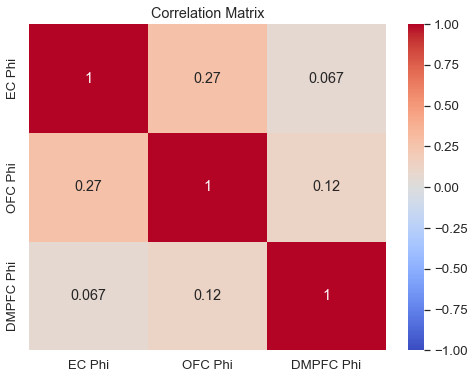

Correlation Matrix:
             EC Phi   OFC Phi  DMPFC Phi
EC Phi     1.000000  0.270484   0.066698
OFC Phi    0.270484  1.000000   0.119970
DMPFC Phi  0.066698  0.119970   1.000000

P-values:
             EC Phi   OFC Phi  DMPFC Phi
EC Phi     1.000000  0.000095   0.344409
OFC Phi    0.000095  1.000000   0.088210
DMPFC Phi  0.344409  0.088210   1.000000


In [91]:
# Create a DataFrame with the phi values
data = pd.DataFrame({'EC Phi': ec_phi, 'OFC Phi': ofc_phi, 'DMPFC Phi': dmpfc_phi})

# Calculate the correlation matrix
corr_matrix = data.corr()

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation Matrix")
plt.show()

# Calculate the correlation matrix and p-values
corr_matrix, p_matrix = data.corr(), data.corr(method=lambda x, y: pearsonr(x, y)[1])
# Print the correlation coefficients and p-values
print("Correlation Matrix:")
print(corr_matrix)
print("\nP-values:")
print(p_matrix)

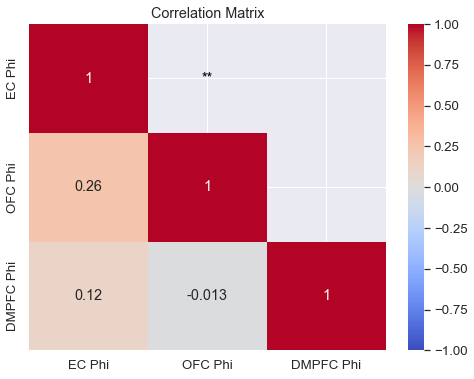

Correlation Matrix:
             EC Phi   OFC Phi  DMPFC Phi
EC Phi     1.000000  0.255611   0.116478
OFC Phi    0.255611  1.000000  -0.013076
DMPFC Phi  0.116478 -0.013076   1.000000

P-values:
             EC Phi   OFC Phi  DMPFC Phi
EC Phi     1.000000  0.000233   0.097935
OFC Phi    0.000233  1.000000   0.853106
DMPFC Phi  0.097935  0.853106   1.000000


In [85]:


# Create a custom triangle plot with p-value stars
plt.figure(figsize=(8, 6))
plt.title("Correlation Matrix")

sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, mask=mask)

# Annotate with stars indicating significance levels
for i in range(corr_matrix.shape[0]):
    for j in range(i + 1, corr_matrix.shape[1]):
        p_value = p_matrix.iloc[i, j]
        if p_value < 0.01:
            plt.text(j + 0.5, i + 0.5, "**", ha='center', va='center', color='black')
        elif p_value < 0.05:
            plt.text(j + 0.5, i + 0.5, "*", ha='center', va='center', color='black')

plt.show()

# Print the correlation coefficients and p-values
print("Correlation Matrix:")
print(corr_matrix)
print("\nP-values:")
print(p_matrix)

In [70]:
ofc_phi

1       1.514550
3      44.854631
5       7.726586
7      16.572618
9      53.920805
         ...    
397    18.487781
399     0.461651
401    22.185199
403    12.819628
405    18.343076
Name: Phi_mean, Length: 203, dtype: float64